<a href="https://colab.research.google.com/github/bemabel/weather-forecasting-LSTM-DL/blob/main/2121_Group3_Modified_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('./PRSA_data_2010.1.1-2014.12.31.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('./pollution.csv')


                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


(43797, 32)
(8760, 24) 8760 (8760,)
(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)
Epoch 1/50
122/122 - 3s - loss: 0.0528 - val_loss: 0.0357
Epoch 2/50
122/122 - 1s - loss: 0.0251 - val_loss: 0.0239
Epoch 3/50
122/122 - 1s - loss: 0.0208 - val_loss: 0.0190
Epoch 4/50
122/122 - 1s - loss: 0.0205 - val_loss: 0.0193
Epoch 5/50
122/122 - 1s - loss: 0.0202 - val_loss: 0.0185
Epoch 6/50
122/122 - 1s - loss: 0.0195 - val_loss: 0.0188
Epoch 7/50
122/122 - 1s - loss: 0.0197 - val_loss: 0.0181
Epoch 8/50
122/122 - 1s - loss: 0.0192 - val_loss: 0.0180
Epoch 9/50
122/122 - 1s - loss: 0.0185 - val_loss: 0.0172
Epoch 10/50
122/122 - 1s - loss: 0.0182 - val_loss: 0.0171
Epoch 11/50
122/122 - 1s - loss: 0.0176 - val_loss: 0.0162
Epoch 12/50
122/122 - 1s - loss: 0.0175 - val_loss: 0.0161
Epoch 13/50
122/122 - 1s - loss: 0.0169 - val_loss: 0.0160
Epoch 14/50
122/122 - 1s - loss: 0.0163 - val_loss: 0.0161
Epoch 15/50
122/122 - 1s - loss: 0.0160 - val_loss: 0.0158
Epoch 16/50
122/122 - 1s - loss: 0.0157 - va

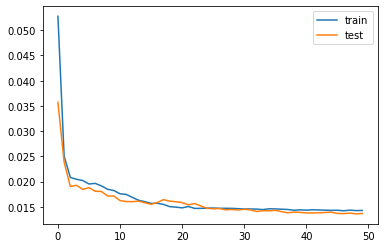

Test RMSE: 26.322


In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('./pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Epoch 1/80
20/20 - 54s - loss: 0.0861 - val_loss: 0.0664
Epoch 2/80
20/20 - 52s - loss: 0.0689 - val_loss: 0.0637
Epoch 3/80
20/20 - 52s - loss: 0.0670 - val_loss: 0.0630
Epoch 4/80
20/20 - 52s - loss: 0.0666 - val_loss: 0.0626
Epoch 5/80
20/20 - 52s - loss: 0.0662 - val_loss: 0.0623
Epoch 6/80
20/20 - 52s - loss: 0.0659 - val_loss: 0.0621
Epoch 7/80
20/20 - 52s - loss: 0.0657 - val_loss: 0.0619
Epoch 8/80
20/20 - 52s - loss: 0.0655 - val_loss: 0.0617
Epoch 9/80
20/20 - 52s - loss: 0.0654 - val_loss: 0.0616
Epoch 10/80
20/20 - 52s - loss: 0.0652 - val_loss: 0.0615
Epoch 11/80
20/20 - 52s - loss: 0.0652 - val_loss: 0.0616
Epoch 12/80
20/20 - 52s - loss: 0.0649 - val_loss: 0.0614
Epoch 13/80
20/20 - 52s - loss: 0.0647 - val_loss: 0.0611
Epoch 14/80
20/20 - 52s - loss: 0.0645 - val_loss: 0.0609
Epoch 15/80
20/20 - 52s - loss: 0.0644 - val_loss: 0.0609
Epoch 16/80
20/20 - 52s - loss: 0.0643 - val_loss: 0.0608
Epoch 17/80
20/20 - 52s - loss: 0.0642 - val_loss: 0.0608
Epoch 18/80
20/20 - 52s

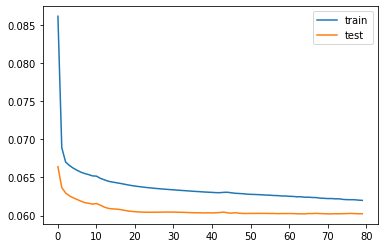

Test RMSE: 87.519


TypeError: ignored

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import ConvLSTM2D

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('./pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode wind direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 24 * 7
n_features = 8
output_steps = 24 * 7
conv_seq = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, output_steps)


# split into train and test sets
values = reframed.values
n_train_hours = int(365 * 24 * 4.5)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
#print(test.shape)
# split into input and outputs
n_obs = n_hours * n_features
y_idx = np.arange(-n_features * output_steps, 0, n_features)
train_X, train_y = train[:, :n_obs], train.take([y_idx], axis=1).reshape(-1, output_steps)
test_X, test_y = test[:, :n_obs], test.take([y_idx], axis=1).reshape(-1, output_steps)



# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# design network
model = Sequential()
#model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_hours, n_features)))
#model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
#model.add(TimeDistributed(Flatten()))
#model.add(Bidirectional(LSTM(64, return_sequences=True)))
#model.add(Bidirectional(ConvLSTM2D(64, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(ConvLSTM2D(64, kernel_size=(1,2), input_shape=(conv_seq, 1, int(n_hours / conv_seq), n_features)))
model.add(Flatten())
#model.add(LSTM(64, return_sequences=True))
#model.add(Bidirectional(LSTM(32)))
model.add(Dense(256))
model.add(Dense(128))
model.add(Dense(output_steps))
model.compile(loss='mae', optimizer='adam')
# fit network
## for conv design
train_X = train_X.reshape(-1, conv_seq, 1, int(n_hours / conv_seq), n_features)
test_X = test_X.reshape(-1, conv_seq, 1, int(n_hours / conv_seq), n_features)

history = model.fit(train_X, train_y, epochs=80, batch_size=2048, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

def detransform(y_out):
    inv_y = np.empty([output_steps, y_out.shape[0], n_features], dtype = float)
    inv_y_ground = np.empty([output_steps, y_out.shape[0], 1], dtype = float)

    for i in range(output_steps):
        #inv_y[i] = concatenate((y_out[:,i:i+1], test[:,-n_features*(output_steps-i)+1:-n_features*(output_steps-i)+n_features]), axis=1)
        inv_y[i] = concatenate((y_out[:,i:i+1], test_X[:, -7:]), axis=1)
        inv_y[i] = scaler.inverse_transform(inv_y[i])
        inv_y_ground[i] = inv_y[i][:,-n_features:-n_features+1]
    return inv_y_ground


# invert scaling for forecast
inv_yhat = detransform(yhat)
# invert scaling for ground truth
#test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = detransform(test_y)

#inv_y = scaler.inverse_transform(test_y)
#inv_y = inv_y[:,0]
# calculate RMSE
rmse = 0
for i in range(output_steps):
    rmse += sqrt(mean_squared_error(inv_y[i], inv_yhat[i]))
rmse = rmse / output_steps
print('Test RMSE: %.3f' % rmse)



In [ ]:
for i in range(3):
    print(i)

0
1
2


(39420, 1, 8) (39420,) (4379, 1, 8) (4379,)
Epoch 1/50
77/77 - 7s - loss: 0.0664 - val_loss: 0.0569
Epoch 2/50
77/77 - 1s - loss: 0.0552 - val_loss: 0.0462
Epoch 3/50
77/77 - 1s - loss: 0.0336 - val_loss: 0.0350
Epoch 4/50
77/77 - 1s - loss: 0.0224 - val_loss: 0.0271
Epoch 5/50
77/77 - 1s - loss: 0.0191 - val_loss: 0.0277
Epoch 6/50
77/77 - 1s - loss: 0.0178 - val_loss: 0.0143
Epoch 7/50
77/77 - 1s - loss: 0.0219 - val_loss: 0.0324
Epoch 8/50
77/77 - 1s - loss: 0.0191 - val_loss: 0.0193
Epoch 9/50
77/77 - 1s - loss: 0.0219 - val_loss: 0.0240
Epoch 10/50
77/77 - 1s - loss: 0.0158 - val_loss: 0.0167
Epoch 11/50
77/77 - 1s - loss: 0.0205 - val_loss: 0.0159
Epoch 12/50
77/77 - 1s - loss: 0.0157 - val_loss: 0.0141
Epoch 13/50
77/77 - 1s - loss: 0.0185 - val_loss: 0.0168
Epoch 14/50
77/77 - 1s - loss: 0.0155 - val_loss: 0.0141
Epoch 15/50
77/77 - 1s - loss: 0.0159 - val_loss: 0.0170
Epoch 16/50
77/77 - 1s - loss: 0.0191 - val_loss: 0.0184
Epoch 17/50
77/77 - 1s - loss: 0.0158 - val_loss: 0.0

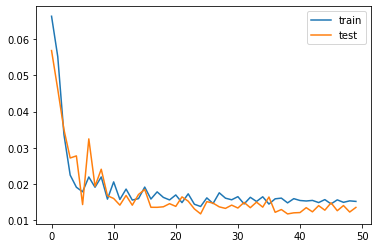

Test RMSE: 24.193


In [ ]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error
import tensorflow as tf

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('./pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#print(reframed.iloc[2, :])

...
# split into train and test sets
values = reframed.values
n_train_hours = int(365 * 24 * 4.5)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

...
# design network
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(64, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(64))  # return a single vector of dimension 32
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=512, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

...
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


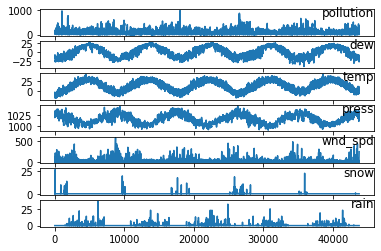

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('./pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()